#### Reading instance and defining model

In [22]:
# Reading instance

from instanceReaderRealInstances import Instance

instanceName = "INST_NA_JO_10.txt"

MV = 10

inst = Instance(instanceName,
                avgSpeed=70,
                model = 'SMDHPDPTW')

In [23]:
# Instance data

df_instance = inst.instance_data

df_instance

,type,county,lat,lon,s,d,w_a,w_b
0,Depot,NATAL,-5.805398,-35.20809,0.0,0.0,0.0,10.0
1,Depot,JOÃO PESSOA,-7.121598,-34.882028,0.0,0.0,0.0,10.0
2,Pickup,NATAL,-5.805398,-35.20809,0.2,4454.0,0.0,10.0
3,Pickup,JOÃO PESSOA,-7.121598,-34.882028,0.2,14056.0,0.0,10.0
4,Delivery,BAÍA FORMOSA,-6.369188,-35.006374,0.3,-665.0,0.0,10.0
5,Delivery,CANGUARETAMA,-6.375194,-35.137463,0.2,-565.0,0.0,10.0
6,Delivery,CEARÁ-MIRIM,-5.632269,-35.421348,0.2,-608.0,0.0,10.0
7,Delivery,JOÃO CÂMARA,-5.534964,-35.815081,0.47,-1454.0,0.0,10.0
8,Delivery,MACAÍBA,-5.856137,-35.352377,0.23,-1162.0,0.0,10.0
9,Delivery,BAIA DA TRAIÇÃO,-6.691258,-34.937124,0.45,-4888.0,0.0,10.0


In [24]:
import pandas as pd

# Importing pyomo modules

import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Creating model
model = pyo.ConcreteModel()

## Defining sets and notation

## $  N = S_{0} \cup P \cup D \cup S_{f} = \{1, ..., 3s + n\} $
## $ S_{0} = \{1, ... , s\} $
## $ P = \{s + 1, ... , 2s\} $
## $ D = \{2s + 1, ... , 2s + n\} $
## $ S_{f} = \{2s + n + 1, ... , 3s + n\} $

#### Vehicles set

## $ \newline K = \{1, ..., m\} $

#### Visits set

## $ \newline V = \{1, ..., MV\} $


In [25]:
# Sets

model.setN = pyo.Set(initialize=range(len(df_instance)))
model.setP = pyo.Set(initialize=df_instance[df_instance['type'] == 'Pickup'].index)
model.setD = pyo.Set(initialize=df_instance[df_instance['type'] == 'Delivery'].index)

# Additional sets

number_of_depots = int(len(df_instance[df_instance['type'] == 'Depot'])/2)
model.setS_0 = pyo.Set(initialize=df_instance[df_instance['type'] == 'Depot'].iloc[:number_of_depots].index)
model.setS_f = pyo.Set(initialize=df_instance[df_instance['type'] == 'Depot'].iloc[-number_of_depots:].index)
model.setS = (model.setS_0 | model.setS_f)


# Set of vehicles
model.setK = pyo.Set(initialize=range(len(inst.K)))

# Set of visits
model.setV = pyo.Set(initialize=range(MV))

#### Defining variables

### $x_{ijkv} = \text{1 if vehicle $k$ travels from $i$ to $j$ in its $v$ visit and 0 otherwise;} $

### $y_{ikv} = \text{amount of load in vehicle $k$ after visiting node $i$ in its $v$ visit;} $

### $w_{ikv} = \text{arrival time of vehicle $k$ in node $i$ in its $v$ visit;} $

### $z_{ikv} = \text{amount of load supplied/delivered by vehicle $k$ to node $i$ in its $v$ visit;} $

In [26]:
# Variables

model.x = pyo.Var(model.setN, model.setN, model.setK, model.setV, within = pyo.Binary)

model.y = pyo.Var(model.setN, model.setK, model.setV, within = NonNegativeReals)

model.w = pyo.Var(model.setN, model.setK, model.setV, within = NonNegativeReals)

model.z = pyo.Var(model.setN, model.setK, model.setV, within = NonNegativeReals)

#### Defining constraints

#### Objective function

## $ (1) $

## $$ max \displaystyle \sum_{i \in D}\displaystyle \sum_{i \in K}\displaystyle \sum_{j \in V}z_{ikv}$$

In [27]:
# (1) - Objective function

model.exprobj = sum(sum(sum(model.z[i,k,v] for i in model.setD) for k in model.setK) for v in model.setV) + 0.001*(sum(sum(sum(sum(model.x[i,i,k,v] for i in model.setN) for i in model.setN) for k in model.setK) for v in model.setV))

model.obj = pyo.Objective(expr= model.exprobj, sense = pyo.maximize)

## $ (2) $


## $$ \displaystyle \sum_{i \in N \setminus S_{f}}x_{ihk(v-1)} -  \displaystyle \sum_{j \in N \setminus S_{0}}x_{hjkv} = 0, \hspace{15pt} \forall h \in P \cup D, k \in K, v \in V \setminus \{0\} $$

In [28]:
# (2) - Flow conservation - if vehicle k goes from i to h, it has to go from h to j on the next visit

model.R2 = pyo.ConstraintList()

for h in (model.setP | model.setD):
    
    for k in model.setK:
        
        for v in range(1,len(model.setV)):

            model.R2.add(expr = sum(model.x[i,h,k,v-1] for i in (model.setN - model.setS_f)) - sum(model.x[h,j,k,v] for j in (model.setN - model.setS_0)) == 0)


## $ (3) $



## $$ \displaystyle \sum_{i \in N}\sum_{j \in N}x_{ijkv} \leq 1, \hspace{15pt} \forall k \in K, v \in V $$

In [29]:
# (3) There can be only one visit per visit index per vehicle

model.R3 = pyo.ConstraintList()
        
for k in model.setK:
    
    for v in model.setV:

        model.R3.add(expr = sum(sum(model.x[i, j, k, v] for i in model.setN) for j in model.setN) <= 1)

## $ (4) $



## $$ \displaystyle x_{ijk0} = 0, \hspace{15pt} \forall i \in N \setminus S_{0} , j \in N , k \in K $$

In [30]:
# (4) - Vehicles must depart from one of the available depots

model.R4 = pyo.ConstraintList()

for i in (model.setN - model.setS_0):
    
    for j in model.setN:
    
        for k in model.setK:
        
            model.R4.add(expr = model.x[i,j,k,0] == 0)

## $ (5) $



## $$ \displaystyle x_{ijkMV} = 0, \hspace{15pt} \forall j \in N \setminus S_{f} , i \in N , k \in K $$

In [31]:
# (5) - Vehicles must end their routes in one of the available depots

model.R5 = pyo.ConstraintList()

for i in model.setN:
    
    for j in (model.setN - model.setS_f):
    
        for k in model.setK:
        
            model.R5.add(expr = model.x[i,j,k,model.setV.bounds()[1]] == 0)

## $ (6) $


## $$ \displaystyle x_{ijk0} = 0,  \hspace{15pt} \forall i \in S_{0}; j \in N \setminus D_{i}; k \in K$$

In [32]:
# (6) - A vehicle can't depart from a depot that is not its initial depot

model.R6 = pyo.ConstraintList()

for i in model.setS_0:

    for j in model.setN:
        
        for k in model.setK:
            
            if (k not in inst.vehicle_locations[i]):
                       
                model.R6.add(expr = model.x[i, j, k, 0] == 0) 

## $ (7) $

## $$ \displaystyle \sum_{j \in N}\sum_{k \in K}x_{ijk0} \leq K_{i}, \hspace{15pt} \forall i \in S_{0} $$

In [33]:
# (7) - Number of vehicles that depart from depot must be equal to number of vehicles available at depot

# K_{i} - Number of vehicles that start their route at depot i in S_0

K = [len(location) for location in inst.vehicle_locations]

model.R7 = pyo.ConstraintList()

for i in (model.setS_0):

    model.R7.add(expr = sum(sum(model.x[i,j,k,0] for j in model.setN) for k in model.setK) <= K[i])

## $ (8) $



## $$ \displaystyle x_{ijkv} = 0, \hspace{15pt} \forall i \in S_{0}, j \in D , k \in K, v \in V $$

In [34]:
# (8) - Vehicles can't go from depot directly to a delivery node (was this supposed to be a constraint?)

model.R8 = pyo.ConstraintList()

for i in model.setS_0:
    
    for j in model.setD:
    
        for k in model.setK:
            
            for v in model.setV:
        
                model.R8.add(expr = model.x[i,j,k,v] == 0)

## $ (9) $



## $$ \displaystyle x_{ijkv} = 0, \hspace{15pt} \forall i \in N, j \in S_{f}, k \in K, v \in V \setminus {MV} $$

In [35]:
# (9) No nodes going to final depot in visits lower than MV

model.R9 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setS_f:
        
        for k in model.setK:

            for v in range(len(model.setV) - 1):

                model.R9.add(expr = model.x[i, j, k, v] == 0)

## $ (10) $



## $$ \displaystyle x_{ijkv} = 0, \hspace{15pt} \forall i \in S_{0}, j \in N, k \in K, v \in V \setminus {0} $$

In [36]:
# (10) No nodes from initial depots in visits higher than 0

model.R10 = pyo.ConstraintList()

for i in model.setS_0:
    
    for j in model.setN:
        
        for k in model.setK:

            for v in range(1, len(model.setV)):

                model.R10.add(expr = model.x[i, j, k, v] == 0)

## $ (11) $

## $$ w_{jkv} \geq w_{ik(v-1)} + t_{ij} - M(1-x_{ijkv}), \newline\forall i \in N, j \in N, k \in K, v \in V \setminus\{0\} $$

In [37]:
# (11) - Time windows constraints - 1

# Defining big M

M = 1000

model.R11 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setN:
        
        for k in model.setK:
    
            for v in range(1, len(model.setV)):
        
                model.R11.add(expr = model.w[j, k, v] >= model.w[i, k, v-1] + inst.c[i][j] - M*(1 - model.x[i,j, k, v]))
            
                model.R11.add(expr = model.w[j, k, v] <= model.w[i, k, v-1] + inst.c[i][j] + M*(1 - model.x[i,j, k, v]))

## $ (11) $



## $$ w_{i}^{a} \leq w_{ikv} \leq w_{i}^{b} , \hspace{15pt} \forall i \in P \cup D, k \in K, v \in V $$

In [38]:
# (11)  - Time windows constraints - 2

# model.R11 = pyo.ConstraintList()

for i in (model.setP | model.setD):
    
    for k in model.setK:
        
        for v in model.setV:
    
            model.R11.add(expr = model.w[i, k, v] >= inst.w_a[i])
            model.R11.add(expr = model.w[i, k, v] <= inst.w_b[i])

## $ (12) $



## $$ y_{jkv} \geq y_{ik(v-1)} + z_{jkv} - M(1-x_{ijkv}), \newline\forall i \in N, j \in P, k \in K, v \in V \setminus \{0\} $$

In [39]:
# (12) - Load constraints - 1 (pickup)

model.R12 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setP:
        
        for k in model.setK:
    
            for v in range(1, len(model.setV)):
        
                model.R12.add(expr = model.y[j,k,v] >= model.y[i,k,v-1] + model.z[j,k,v] - M*(1 - model.x[i,j,k,v]))
            
                model.R12.add(expr = model.y[j,k,v] <= model.y[i,k,v-1] + model.z[j,k,v] + M*(1 - model.x[i,j,k,v]))
                
# (12) - Load constraints - first pickup

for i in model.setN:
        
    for k in model.setK:

            model.R12.add(expr = model.y[i,k,0] >= model.z[i,k,0])

            model.R12.add(expr = model.y[i,k,0] <= model.z[i,k,0])

## $ (13) $



## $$ y_{jkv} \geq y_{ik(v-1)} - z_{jkv} - M(1-x_{ijkv}), \newline\forall i \in N, j \in D, k \in K, v \in V \setminus \{0\} $$

In [40]:
# (13)  - Load constraints - 2 (delivery)

model.R13 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setD:
        
        for k in model.setK:
    
            for v in range(1, len(model.setV)):
            
                model.R13.add(expr = model.y[j,k,v] >= model.y[i,k,v-1] - model.z[j,k,v] - M*(1 - model.x[i,j,k,v]))
                
                model.R13.add(expr = model.y[j,k,v] <= model.y[i,k,v-1] - model.z[j,k,v] + M*(1 - model.x[i,j,k,v]))

## $ (14) $



## $$ \displaystyle y_{ikv} \leq Q_{k}, \hspace{15pt} \forall i \in N , k \in K, v \in V$$

In [41]:
# (14) - Load constraints - 3

model.R14 = pyo.ConstraintList()

for i in model.setN:

        for k in model.setK:

            for v in model.setV:

                model.R14.add(expr = model.y[i,k,v] <= inst.K[k])

## $ (15) $


## $$ \displaystyle \sum_{k \in K}\sum_{v \in V} z_{ikv} \leq d_{i}, \hspace{15pt} \forall i \in P \cup D $$

In [42]:
# (15)  - Total amount picked up/delivered to each node can't be above node supply/demand

model.R15 = pyo.ConstraintList()

for i in (model.setP | model.setD):

    model.R15.add(expr = sum(sum(model.z[i, k, v] for k in model.setK) for v in model.setV) <= abs(inst.d[i]))

## $ (16) $


## $$  z_{ikv} \leq d_{i}\displaystyle \sum_{j \in N}x_{jikv}, \hspace{15pt} \forall i \in N, k \in K, v \in V $$

In [43]:
# (16) - Amount delivered to a node in a single visit can't exceed node demand

model.R16 = pyo.ConstraintList()

for i in model.setN:
    
    for k in model.setK:
        
        for v in model.setV:

            model.R16.add(expr = model.z[i, k, v] <= abs(inst.d[i])*sum(model.x[j,i,k,v] for j in model.setN))

## $ (17) $


## $$  \displaystyle \sum_{i \in P}\sum_{v \in V} z_{ikv} =\displaystyle \sum_{i \in D}\sum_{v \in V}z_{ikv}, \forall k \in K$$

In [44]:
# (17) - Total delivered amount by a vehicle needs to be equal to total picked up demand

model.R17 = pyo.ConstraintList()

for k in model.setK:
    
    model.R17.add(expr = sum(sum(model.z[i, k, v] for i in model.setP) for v in model.setV) == sum(sum(model.z[i, k, v] for i in model.setD) for v in model.setV))


## $ (18) $


## $$ M(1-x_{iikv}) \leq z_{ikv} \leq -M(1-x_{iikv}), \forall i \in N; k \in K; v \in V $$

In [45]:
# (18) if "fake visit", no load is picked up/delivered

model.R18 = pyo.ConstraintList()

for i in model.setN:
        
    for k in model.setK:
        
        for v in model.setV:

            model.R18.add(expr = model.z[i,k,v] <= M*(1-model.x[i, i, k, v]))
            model.R18.add(expr = model.z[i,k,v] >= (-1)*M*(1-model.x[i, i, k, v]))

In [46]:
# No arcs between pickup nodes (is this necessary?)

model.RPP = pyo.ConstraintList()

for i in model.setP:
    
    for j in model.setP:
        
        for k in model.setK:

            for v in model.setV:

                model.RPP.add(expr = model.x[i, j, k, v] == 0)

In [47]:
# (19) - Forces that a vehicle can't go to a pickup node that is not in the same place of its initial depot

model.R22 = pyo.ConstraintList()

for i in model.setS_0:

    for j in model.setP:
        
        for k in model.setK:
            
            if (inst.c[i][j] > 0):

                model.R22.add(expr = model.x[i, j, k, 0] == 0)

#### Valid inequalities

In [48]:
# # Inequalities for N set

model.VI1 = pyo.ConstraintList()

# No "node to initial depot" arcs or "final depot to nodes" arcs

for i in model.setN:
    
    for k in model.setK:
        
        for v in model.setV:
    
            #model.VI1.add(expr= model.x[i, i, k, v] == 0)

            for h in model.setS_0:

                model.VI1.add(expr= model.x[i, h, k, v] == 0)

            for h in model.setS_f:

                model.VI1.add(expr= model.x[h, i, k, v] == 0)
                

# Vehicles can't visit pickup node right before ending route

model.RV2 = pyo.ConstraintList()

for i in model.setP:
    
    for j in model.setS_f:
    
        for k in model.setK:
        
            model.RV2.add(expr = model.x[i,j,k,model.setV.bounds()[1]] == 0)


# Time windows inequalities

model.VI3 = pyo.ConstraintList()

for i in (model.setP | model.setD):
    
    for j in (model.setP | model.setD):
        
        for k in model.setK:
            
            for v in model.setV:
        
                if inst.w_a[i] + inst.c[i][j] > inst.w_b[j]:

                    model.VI3.add(expr= model.x[i, j, k, v] == 0)


In [ ]:
# # "Equity" constraint

# demand_fraction = 0.05

# model.REQ = pyo.ConstraintList()

# for i in model.setD:
    
#     model.REQ.add(expr= sum(sum(model.z[i,k,v] for k in model.setK) for v in model.setV) >= abs(d[i])*demand_fraction)

#### Solving model

In [49]:
# Solver

TimeLimit = 2000

opt = pyo.SolverFactory('cplex', executable='C:/Program Files/IBM/ILOG/CPLEX_Studio201/cplex/bin/x64_win64/cplex')
opt.options['TimeLimit'] = TimeLimit


results = opt.solve(model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\User\AppData\Local\Temp\tmpml6539s2.cplex.log' open.
CPLEX> New value for time limit in seconds: 2000
CPLEX> Problem 'C:\Users\User\AppData\Local\Temp\tmplylk7a_d.pyomo.lp' read.
Read time = 0.11 sec. (5.68 ticks)
CPLEX> Problem name         : C:\Users\User\AppData\Local\Temp\tmplylk7a_d.pyomo.lp
Objective sense      : Maximize
Variables            :   15201  [Nneg: 2401,  Binary: 12800]
Objective nonzeros   :    1300
Linear constraints   :   56220  [Less: 44344,  Greater: 600,  Equal: 11276]
  Nonzeros           :  194171
  RHS nonzeros       :   43385

Variables            : Min LB:

In [50]:
for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if (pyo.value(model.x[i,j,k,v]))>0.01:

                    print(f'x[{i}, {j}, {k}, {v}] == {pyo.value(model.x[i,j,k,v])}')

x[0, 2, 0, 0] == 1.0
x[2, 12, 0, 1] == 1.0
x[12, 3, 0, 2] == 1.0
x[3, 9, 0, 3] == 1.0
x[9, 9, 0, 4] == 1.0
x[9, 3, 0, 5] == 1.0
x[3, 13, 0, 6] == 1.0
x[13, 2, 0, 7] == 1.0
x[2, 13, 0, 8] == 1.0
x[13, 14, 0, 9] == 1.0
x[0, 2, 1, 0] == 1.0
x[2, 12, 1, 1] == 1.0
x[12, 3, 1, 2] == 1.0
x[3, 12, 1, 3] == 1.0
x[12, 3, 1, 4] == 1.0
x[3, 12, 1, 5] == 1.0
x[12, 3, 1, 6] == 1.0
x[3, 12, 1, 7] == 1.0
x[12, 12, 1, 8] == 1.0
x[12, 15, 1, 9] == 1.0
x[1, 3, 2, 0] == 1.0
x[3, 9, 2, 1] == 1.0
x[9, 9, 2, 2] == 1.0
x[9, 2, 2, 3] == 1.0
x[2, 6, 2, 4] == 1.0
x[6, 2, 2, 5] == 1.0
x[2, 7, 2, 6] == 1.0
x[7, 3, 2, 7] == 1.0
x[3, 12, 2, 8] == 1.0
x[12, 15, 2, 9] == 1.0
x[1, 3, 3, 0] == 1.0
x[3, 13, 3, 1] == 1.0
x[13, 13, 3, 2] == 1.0
x[13, 3, 3, 3] == 1.0
x[3, 4, 3, 4] == 1.0
x[4, 2, 3, 5] == 1.0
x[2, 5, 3, 6] == 1.0
x[5, 3, 3, 7] == 1.0
x[3, 9, 3, 8] == 1.0
x[9, 15, 3, 9] == 1.0
x[1, 3, 4, 0] == 1.0
x[3, 12, 4, 1] == 1.0
x[12, 3, 4, 2] == 1.0
x[3, 13, 4, 3] == 1.0
x[13, 13, 4, 4] == 1.0
x[13, 3, 4, 5] == 1.0
x[

In [52]:
for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if ((pyo.value(model.x[i,j,k,v]))>0.01):

                    print(f'z[{j}, {k}, {v}] == {pyo.value(model.z[j,k,v])}')

z[2, 0, 0] == 700.0
z[12, 0, 1] == 700.0000000000001
z[3, 0, 2] == 700.0000000000001
z[9, 0, 3] == 700.0000000000001
z[9, 0, 4] == 0.0
z[3, 0, 5] == 700.0000000000001
z[13, 0, 6] == 699.9999999999999
z[2, 0, 7] == 700.0000000000001
z[13, 0, 8] == 700.0
z[14, 0, 9] == 0.0
z[2, 1, 0] == 700.0
z[12, 1, 1] == 700.0000000000001
z[3, 1, 2] == 700.0000000000001
z[12, 1, 3] == 700.0000000000001
z[3, 1, 4] == 700.0000000000001
z[12, 1, 5] == 700.0000000000001
z[3, 1, 6] == 700.0000000000001
z[12, 1, 7] == 700.0000000000001
z[12, 1, 8] == 0.0
z[15, 1, 9] == 0.0
z[3, 2, 0] == 550.0
z[9, 2, 1] == 550.0000000000001
z[9, 2, 2] == 0.0
z[2, 2, 3] == 550.0
z[6, 2, 4] == 550.0000000000001
z[2, 2, 5] == 550.0
z[7, 2, 6] == 550.0000000010001
z[3, 2, 7] == 550.0000000000001
z[12, 2, 8] == 549.9999999989999
z[15, 2, 9] == 0.0
z[3, 3, 0] == 550.0
z[13, 3, 1] == 550.0
z[13, 3, 2] == 0.0
z[3, 3, 3] == 550.0
z[4, 3, 4] == 550.0
z[2, 3, 5] == 550.0000000000001
z[5, 3, 6] == 550.0000000000005
z[3, 3, 7] == 550.0


In [54]:
for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if ((pyo.value(model.x[i,j,k,v]))>0.01):

                    print(f'y[{j}, {k}, {v}] == {pyo.value(model.y[j,k,v])}')

y[2, 0, 0] == 700.0
y[12, 0, 1] == 0.0
y[3, 0, 2] == 700.0
y[9, 0, 3] == 0.0
y[9, 0, 4] == 0.0
y[3, 0, 5] == 699.9999999999999
y[13, 0, 6] == 0.0
y[2, 0, 7] == 700.0
y[13, 0, 8] == 0.0
y[14, 0, 9] == 0.0
y[2, 1, 0] == 700.0
y[12, 1, 1] == 0.0
y[3, 1, 2] == 700.0
y[12, 1, 3] == 0.0
y[3, 1, 4] == 700.0
y[12, 1, 5] == 0.0
y[3, 1, 6] == 700.0
y[12, 1, 7] == 0.0
y[12, 1, 8] == 0.0
y[15, 1, 9] == 0.0
y[3, 2, 0] == 550.0
y[9, 2, 1] == 0.0
y[9, 2, 2] == 0.0
y[2, 2, 3] == 550.0
y[6, 2, 4] == 0.0
y[2, 2, 5] == 550.0
y[7, 2, 6] == 0.0
y[3, 2, 7] == 550.0
y[12, 2, 8] == 1.0001031114370562e-09
y[15, 2, 9] == 0.0
y[3, 3, 0] == 550.0
y[13, 3, 1] == 0.0
y[13, 3, 2] == 0.0
y[3, 3, 3] == 550.0
y[4, 3, 4] == 0.0
y[2, 3, 5] == 550.0
y[5, 3, 6] == 0.0
y[3, 3, 7] == 550.0
y[9, 3, 8] == 0.0
y[15, 3, 9] == 0.0
y[3, 4, 0] == 550.0
y[12, 4, 1] == 0.0
y[3, 4, 2] == 550.0
y[13, 4, 3] == 0.0
y[13, 4, 4] == 0.0
y[3, 4, 5] == 550.0
y[8, 4, 6] == 0.0
y[3, 4, 7] == 550.0
y[12, 4, 8] == 1.0005578587879427e-09
y[14, 4, 

In [55]:
for k in model.setK:

    for v in model.setV:

        for i in model.setN:
            
            for j in model.setN:
            
                if pyo.value(model.x[i,j,k,v]) > 0.01:

                    print(f'w[{j}, {k}, {v}] == {pyo.value(model.w[j,k,v])}')
                    

w[2, 0, 0] == 0.0
w[12, 0, 1] == 2.058999999999969
w[3, 0, 2] == 3.0109999999999673
w[9, 0, 3] == 4.16599999999994
w[9, 0, 4] == 4.16599999999994
w[3, 0, 5] == 5.305999999999926
w[13, 0, 6] == 6.141999999999939
w[2, 0, 7] == 8.069999999999936
w[13, 0, 8] == 9.997999999999934
w[14, 0, 9] == 11.92599999999993
w[2, 1, 0] == 0.0
w[12, 1, 1] == 2.058999999999969
w[3, 1, 2] == 3.010999999999961
w[12, 1, 3] == 3.9779999999999456
w[3, 1, 4] == 4.929999999999944
w[12, 1, 5] == 5.896999999999928
w[3, 1, 6] == 6.8489999999999265
w[12, 1, 7] == 7.815999999999911
w[12, 1, 8] == 7.815999999999911
w[15, 1, 9] == 8.767999999999908
w[3, 2, 0] == 0.0
w[9, 2, 1] == 1.1549999999999727
w[9, 2, 2] == 1.1549999999999674
w[2, 2, 3] == 2.937999999999983
w[6, 2, 4] == 3.5239999999999956
w[2, 2, 5] == 4.110000000000008
w[7, 2, 6] == 5.358000000000056
w[3, 2, 7] == 8.942000000000002
w[12, 2, 8] == 9.908999999999986
w[15, 2, 9] == 10.860999999999985
w[3, 3, 0] == 0.0
w[13, 3, 1] == 0.8360000000000127
w[13, 3, 2] =

In [56]:
# Getting routes on solution

routes = [[] for k in model.setK]

for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if (pyo.value(model.x[i,j,k,v]))>0.01:
                    
                    if len(routes[k]) == 0:
                    
                        routes[k].extend([i,j])
                        
                    else:
                        
                        routes[k].append(j)

# print(routes)

In [57]:
routes = [route for route in routes if len(route) > 0]

In [87]:
real_routes = []

for route in routes:
    
    print('[', end="")
    
    real_route = [route[0]]
    
    for index_node in range(1,len(route)):
        
        if route[index_node-1] != route[index_node]:
        
            print(route[index_node-1], end=" ")
            real_route.append(route[index_node])
        
    real_routes.append(real_route)
        
    print(route[index_node], end="")
    
    print(']\n')

[0 2 12 3 9 3 13 2 13 14]

[0 2 12 3 12 3 12 3 12 15]

[1 3 9 2 6 2 7 3 12 15]

[1 3 13 3 4 2 5 3 9 15]

[1 3 12 3 13 3 8 3 12 14]



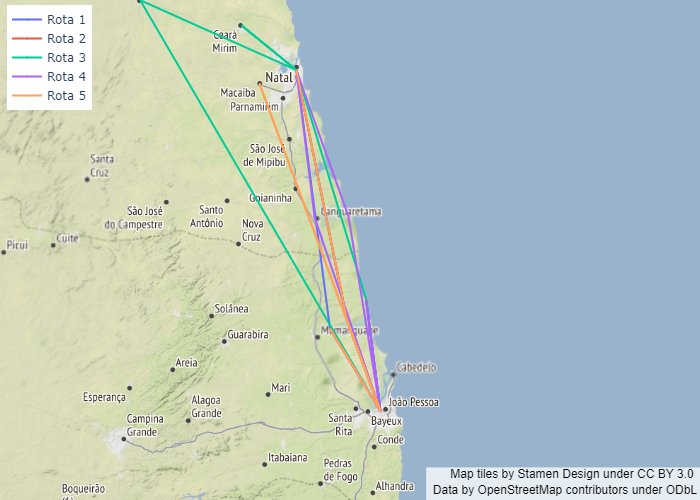

In [141]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon =  df_instance['lon'],
    lat = df_instance['lat'],
    hovertext = df_instance['county'],
    hoverinfo = 'text',
    visible=False,
    marker = {'size': 10}))

for index, route in enumerate(real_routes):
    
    lons = [df_instance['lon'].iloc[node] for node in route]
    lats = [df_instance['lat'].iloc[node] for node in route]
    
    fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = lons,
    lat = lats,
    hovertext = df_instance['county'],
    hoverinfo = 'text',
    name = 'Rota ' + str(index + 1),
    marker = {'size': 2}))
        
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': -35, 'lat': -6.5},
        'zoom': 7.5})

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show("png")